In [2]:
import pandas as pd
import numpy as np
from rdkit import Chem
import matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix, 
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score,
    roc_auc_score,
    roc_curve
)

In [76]:
def load_datasets():
    """Load the datasets from specified CSV files."""
    # Read the CSV files into DataFrames
    nx_dataset = pd.read_csv('/Users/aleksashka/Comparison/Data/nx_data_preprocessed.csv')
    admetica_dataset = pd.read_csv('/Users/aleksashka/Comparison/Data/3A4/admetica_cyp3a4-inhibitor_curated.csv')
    chembl_dataset = pd.read_csv('/Users/aleksashka/Comparison/Data/3A4/ChEMBL_30_3A4.csv')
    return nx_dataset, admetica_dataset, chembl_dataset

def canonicalize(smiles_list):
    """Canonicalize a list of SMILES strings."""
    # Convert each SMILES string to its canonical form and return a set of unique canonical SMILES
    return {Chem.CanonSmiles(smiles) for smiles in smiles_list}

def compare_smiles(list1, list2):
    """Compare two lists of SMILES and return common canonicalized representations."""
    # Canonicalize both lists
    canon_list1 = canonicalize(list1)
    canon_list2 = canonicalize(list2)
    
    # Find common canonical SMILES between the two lists
    common_smiles = canon_list1.intersection(canon_list2)
    
    return common_smiles

def filter_chembl_data(chembl_dataset, common_canon_smiles):
    """Filter the ChEMBL dataset based on common SMILES and process the values."""
    # Filter the dataset to include only entries with common canonical SMILES
    filtered_chembl_dataset = chembl_dataset[chembl_dataset['molecule_smiles'].isin(common_canon_smiles)]
    
    # Remove duplicates, giving priority to IC50
    filtered_chembl_dataset['priority'] = filtered_chembl_dataset['Type'].apply(lambda x: 0 if x == 'IC50' else 1)
    filtered_chembl_dataset = filtered_chembl_dataset.sort_values(by=['priority', 'Type'], ascending=[True, True])
    filtered_chembl_dataset = filtered_chembl_dataset.drop_duplicates(subset=['molecule_smiles'], keep='first')

    # Remove specific unwanted types from the dataset
    remove_values = ['Drug metabolism', 'FC', 'Retention_time', 'T1/2', 'mechanism based inhibition', 'Stability']
    filtered_chembl_dataset = filtered_chembl_dataset[~filtered_chembl_dataset['Type'].isin(remove_values)]
    filtered_chembl_dataset = filtered_chembl_dataset.dropna(subset=['Unit'])

    #Remove specific unwanted units from the dataset
    remove_units = ['uL/min', '10\'-4/min']
    filtered_chembl_dataset = filtered_chembl_dataset[~filtered_chembl_dataset['Unit'].isin(remove_units)]
    
    # Filter out 'Activity' entries that do not have the correct unit
    filtered_chembl_dataset = filtered_chembl_dataset[
        ~((filtered_chembl_dataset['Type'] == 'Activity') & (filtered_chembl_dataset['Unit'] != 'uM'))
    ]

    # Process 'Value' based on 'Type' to create a new column
    filtered_chembl_dataset['Processed_Value'] = filtered_chembl_dataset.apply(process_value, axis=1)
    
    # Drop rows with NaN values in 'Processed_Value'
    filtered_chembl_dataset = filtered_chembl_dataset.dropna(subset=['Processed_Value'])

    # Classify entries based on the processed values (binary classification)
    filtered_chembl_dataset['Class'] = filtered_chembl_dataset['Processed_Value'].apply(lambda x: 1 if x < 3 else 0)

    return filtered_chembl_dataset

def process_value(row):
    """Apply different operations to 'Value' based on 'Type'."""
    type_val = row['Type']
    value = row['Value']
    
    # Attempt to convert value to float; if unsuccessful, return NaN
    try:
        value = float(value)  # Convert value to float
    except (ValueError, TypeError):
        return np.nan  # Return NaN if conversion fails
    
    # Perform operations based on the 'Type' of measurement
    if type_val in ['IC50', 'AC50', 'KI', 'Potency']:
        return value / 1000  # Convert to uM for these types
    elif type_val == 'Inhibition':
        return 1 if value > 50 else 0  # Binary classification based on inhibition percentage
    elif type_val == 'Activity':
        return value  # Keep the original value for Activity
    else:
        return value  # Return the value as is for other types

def main():
    # Load datasets from CSV files
    nx_dataset, admetica_dataset, chembl_dataset = load_datasets()

    # Extract SMILES lists from each dataset
    nx_smiles = nx_dataset['smiles'].tolist()
    chembl_smiles = chembl_dataset['molecule_smiles'].tolist()
    admetica_smiles = admetica_dataset['smiles'].tolist()

    # Compare and find common SMILES between NX and ChEMBL datasets
    common_canon_smiles = compare_smiles(nx_smiles, chembl_smiles)
    print(f"Number of common SMILES between NX and ChEMBL: {len(common_canon_smiles)}")

    # Filter the ChEMBL dataset based on the common SMILES found
    filtered_chembl_dataset = filter_chembl_data(chembl_dataset, common_canon_smiles)
    print(f"Filtered ChEMBL dataset shape: {filtered_chembl_dataset.shape}")

    # Further filtering against the Admetica dataset to exclude overlapping SMILES
    common_canon_smiles_admetica = compare_smiles(admetica_smiles, filtered_chembl_dataset['molecule_smiles'].tolist())
    filtered_chembl_dataset = filtered_chembl_dataset[~filtered_chembl_dataset['molecule_smiles'].isin(common_canon_smiles_admetica)]
    print(f"Filtered ChEMBL dataset shape after removing common SMILES with Admetica: {filtered_chembl_dataset.shape}")

    # Class distribution in the filtered dataset
    class_counts = filtered_chembl_dataset['Class'].value_counts()
    print(f"Class distribution:\n{class_counts}")
    
    # Print detailed information about classes and counts
    print(f"Total classes: {len(class_counts)}")
    for class_label, count in class_counts.items():
        print(f"Class {class_label}: {count} entries")

    # Final processing for NX dataset based on remaining common SMILES
    filtered_chembl_smiles = filtered_chembl_dataset['molecule_smiles'].tolist()
    common_canon_smiles_final = compare_smiles(filtered_chembl_smiles, nx_smiles)
    nx_filtered = nx_dataset[nx_dataset['smiles'].isin(common_canon_smiles_final)]
    
    # Sort the NX dataset based on the order of filtered ChEMBL SMILES
    order = {smile: idx for idx, smile in enumerate(filtered_chembl_smiles) if smile in common_canon_smiles_final}
    nx_sorted = nx_filtered.sort_values(by='smiles', key=lambda x: x.map(order)).reset_index(drop=True)

    # Save the final datasets to CSV files
    filtered_chembl_dataset.to_csv('chembl_2C9.csv', index=False)
    nx_sorted.to_csv('nx_2C9.csv', index=False)

if __name__ == "__main__":
    main()

Number of common SMILES between NX and ChEMBL: 1279
Filtered ChEMBL dataset shape: (841, 25)


/var/folders/4z/y762cxgx769fwlmj9f5cw6s00000gn/T/ipykernel_24720/2413357218.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_chembl_dataset['priority'] = filtered_chembl_dataset['Type'].apply(lambda x: 0 if x == 'IC50' else 1)


Filtered ChEMBL dataset shape after removing common SMILES with Admetica: (788, 25)
Class distribution:
Class
0    549
1    239
Name: count, dtype: int64
Total classes: 2
Class 0: 549 entries
Class 1: 239 entries


In [79]:
import numpy as np
import pandas as pd
from sklearn.metrics import roc_curve, confusion_matrix, roc_auc_score
from tabulate import tabulate  # Importing the tabulate library

def analyze_threshold_performance(y_true, y_pred_prob, threshold_step=0.1, nx=True):
    """
    Analyzes the performance of a binary classifier at various thresholds to determine
    the optimal threshold that maximizes balanced accuracy, and calculates AUC.

    Parameters:
        y_true (array-like): True class labels.
        y_pred_prob (array-like): Predicted probabilities for the positive class.
        threshold_step (float, optional): Step size for threshold evaluation (default is 0.1).
    
    Returns:
        dict: A dictionary containing the optimal threshold, performance metrics (TP, TN, FP, FN),
              sensitivity, specificity, balanced accuracy, and AUC score.
    """
    # Step 1: Compute ROC curve data (FPR, TPR, and thresholds)
    fpr, tpr, roc_thresholds = roc_curve(y_true, y_pred_prob)

    # Step 2: Calculate specificity at each threshold
    specificity = 1 - fpr
    sensitivity = tpr  # TPR is the same as recall

    # Step 3: Compute balanced accuracy at each threshold
    balanced_accuracy = (sensitivity + specificity) / 2

    # Step 4: Create a DataFrame to hold TP, TN, FP, FN for every threshold
    results = []
    max_threshold = np.ceil(y_pred_prob.max() * 10) / 10  # Round up to the nearest 0.1
    thresholds_to_evaluate = np.arange(0.0, max_threshold + threshold_step, threshold_step)  # Range of thresholds

    for threshold in thresholds_to_evaluate:
        if nx:
            y_pred = np.where(y_pred_prob >= threshold, 0, 1)
        else:
            y_pred = np.where(y_pred_prob >= threshold, 1, 0)
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

        # Store the results
        results.append({
            'Threshold': threshold,
            'TP': tp,
            'TN': tn,
            'FP': fp,
            'FN': fn,
            'Sensitivity': tp / (tp + fn) if (tp + fn) > 0 else 0,
            'Specificity': tn / (tn + fp) if (tn + fp) > 0 else 0,
            'Balanced Accuracy': (tp / (tp + fn) + tn / (tn + fp)) / 2
        })

    # Convert results to DataFrame
    results_df = pd.DataFrame(results)

    # Step 5: Find the threshold that maximizes balanced accuracy
    optimal_idx_balanced_acc = np.argmax(results_df['Balanced Accuracy'])
    optimal_threshold_balanced_acc = results_df['Threshold'].iloc[optimal_idx_balanced_acc]

    # Step 6: Get optimal performance metrics
    optimal_results = results_df.iloc[optimal_idx_balanced_acc]

    # Step 7: Calculate AUC for the entire set of probabilities at the optimal threshold
    if nx:
        y_pred = np.where(y_pred_prob > optimal_threshold_balanced_acc, 0, 1)
    else:
        y_pred = np.where(y_pred_prob > optimal_threshold_balanced_acc, 1, 0)
    auc = roc_auc_score(y_true, y_pred)

    # Step 8: Create performance summary
    performance_summary = {
        'Metric': [
            #'Optimal Threshold',
            'True Positives (TP)',
            'True Negatives (TN)',
            'False Positives (FP)',
            'False Negatives (FN)',
            'Sensitivity (Recall)',
            'Specificity',
            'Balanced Accuracy',
            'AUC'
        ],
        'Value': [
            #optimal_threshold_balanced_acc,
            optimal_results['TP'],
            optimal_results['TN'],
            optimal_results['FP'],
            optimal_results['FN'],
            optimal_results['Sensitivity'],
            optimal_results['Specificity'],
            optimal_results['Balanced Accuracy'],
            auc
        ]
    }

    # Convert performance summary to DataFrame for tabulation
    performance_df = pd.DataFrame(performance_summary)

    # Print the performance summary in a nice table format
    if nx:
        print("\nPerformance Summary for Novartis dataset:")
    else:
        print("\nPerformance Summary:")
    print(tabulate(performance_df, headers='keys', tablefmt='pretty'))

    return {
        'Optimal Threshold': optimal_threshold_balanced_acc,
        'True Positives (TP)': optimal_results['TP'],
        'True Negatives (TN)': optimal_results['TN'],
        'False Positives (FP)': optimal_results['FP'],
        'False Negatives (FN)': optimal_results['FN'],
        'Sensitivity (Recall)': optimal_results['Sensitivity'],
        'Specificity': optimal_results['Specificity'],
        'Balanced Accuracy': optimal_results['Balanced Accuracy'],
        'AUC': auc,
        'fpr': fpr,  # False positive rate for ROC curve
        'tpr': tpr 
    }


chembl_dataset = pd.read_csv('/Users/aleksashka/Comparison/CYP2D6/chembl_2D6.csv')
nx_dataset = pd.read_csv('/Users/aleksashka/Comparison/CYP2D6/nx_2D6.csv')
admetica_dataset = pd.read_csv('/Users/aleksashka/Comparison/CYP2D6/admetica_2D6.csv')
y_true = chembl_dataset['Class']
y_pred_prob_nx = nx_dataset['pred(CYP2D6_pIC50)_log']
results = analyze_threshold_performance(y_true, y_pred_prob_nx, 0.1, True)

y_pred_prob_admet = admetica_dataset['CYP2D6-Inhibitor']
results = analyze_threshold_performance(y_true, y_pred_prob_admet, 0.1, False)


Performance Summary for Novartis dataset:
+---+----------------------+---------------------+
|   |        Metric        |        Value        |
+---+----------------------+---------------------+
| 0 | True Positives (TP)  |        55.0         |
| 1 | True Negatives (TN)  |        403.0        |
| 2 | False Positives (FP) |        41.0         |
| 3 | False Negatives (FN) |        140.0        |
| 4 | Sensitivity (Recall) | 0.28205128205128205 |
| 5 |     Specificity      | 0.9076576576576577  |
| 6 |  Balanced Accuracy   | 0.5948544698544699  |
| 7 |         AUC          | 0.5948544698544698  |
+---+----------------------+---------------------+

Performance Summary:
+---+----------------------+--------------------+
|   |        Metric        |       Value        |
+---+----------------------+--------------------+
| 0 | True Positives (TP)  |        88.0        |
| 1 | True Negatives (TN)  |       329.0        |
| 2 | False Positives (FP) |       115.0        |
| 3 | False Negatives (


Performance Summary:
+---+----------------------+--------------------+
|   |        Metric        |       Value        |
+---+----------------------+--------------------+
| 0 | True Positives (TP)  |        88.0        |
| 1 | True Negatives (TN)  |       329.0        |
| 2 | False Positives (FP) |       115.0        |
| 3 | False Negatives (FN) |       107.0        |
| 4 | Sensitivity (Recall) | 0.4512820512820513 |
| 5 |     Specificity      | 0.740990990990991  |
| 6 |  Balanced Accuracy   | 0.5961365211365212 |
| 7 |         AUC          | 0.596136521136521  |
+---+----------------------+--------------------+

Performance Summary for Novartis dataset:
+---+----------------------+---------------------+
|   |        Metric        |        Value        |
+---+----------------------+---------------------+
| 0 | True Positives (TP)  |        55.0         |
| 1 | True Negatives (TN)  |        403.0        |
| 2 | False Positives (FP) |        41.0         |
| 3 | False Negatives (FN) | 

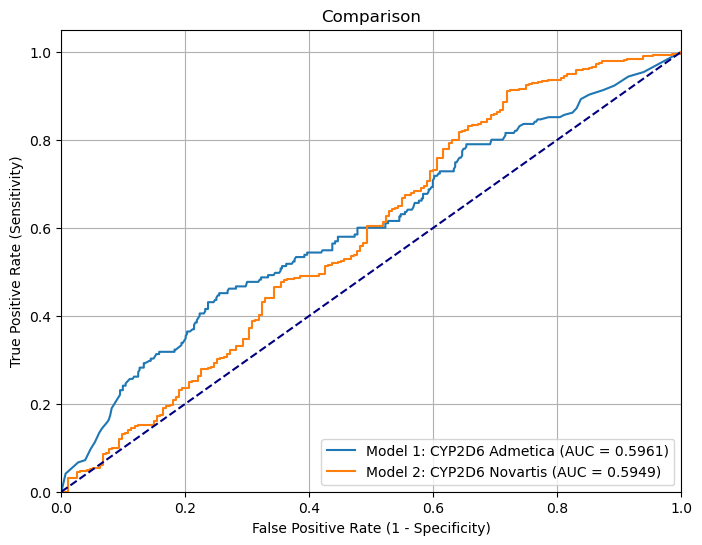

In [80]:
def compare_models_roc(y_true_1, y_pred_prob_1, label_1, y_true_2, y_pred_prob_2, label_2, threshold_step=0.1):
    """
    Compares two models by plotting their ROC curves and AUC scores on the same plot.

    Parameters:
        y_true_1 (array-like): True labels for model 1.
        y_pred_prob_1 (array-like): Predicted probabilities for model 1.
        label_1 (str): Label for model 1 in the plot.
        y_true_2 (array-like): True labels for model 2.
        y_pred_prob_2 (array-like): Predicted probabilities for model 2.
        label_2 (str): Label for model 2 in the plot.
        threshold_step (float, optional): Step size for threshold evaluation (default is 0.1).
    
    Returns:
        None: This function directly plots the ROC curve comparison.
    """
    # Analyze performance for both models
    results_1 = analyze_threshold_performance(y_true_1, y_pred_prob_1, threshold_step, False)
    results_2 = analyze_threshold_performance(y_true_2, y_pred_prob_2, threshold_step, True)

    # Plot ROC curves
    plt.figure(figsize=(8, 6))
    
    # Plot model 1 ROC curve
    plt.plot(results_1['fpr'], results_1['tpr'], label=f'{label_1} (AUC = {results_1["AUC"]:.4f})')
    
    # Plot model 2 ROC curve
    plt.plot(results_2['tpr'], results_2['fpr'], label=f'{label_2} (AUC = {results_2["AUC"]:.4f})')

    # Plot settings
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')  # Diagonal line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (1 - Specificity)')
    plt.ylabel('True Positive Rate (Sensitivity)')
    plt.title('Comparison')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()


# Compare the models
compare_models_roc(y_true, y_pred_prob_admet, 'Model 1: CYP2D6 Admetica', y_true, y_pred_prob_nx, 'Model 2: CYP2D6 Novartis')